In [1]:
import collections

import datasets
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
import tqdm
import transformers

/Users/minlingzhou/miniconda3/envs/my-env/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
seed = 1234

np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True

In [3]:
train_valid_data, test_data = datasets.load_dataset(
    "yelp_polarity", split=["train", "test"]
)

In [4]:
train_valid_split = train_valid_data.train_test_split(test_size=0.2)
train_data = train_valid_split["train"]
valid_data = train_valid_split["test"]
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 448000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 112000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 38000
 }))

In [5]:
# with small dataset
train_data = train_data.train_test_split(test_size=0.999)["train"]
valid_data = valid_data.train_test_split(test_size=0.001)["test"]
test_data = test_data.train_test_split(test_size=0.001)["test"]
train_data, valid_data, test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 448
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 112
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 38
 }))

In [6]:
transformer_name = "bert-base-uncased"

tokenizer = transformers.AutoTokenizer.from_pretrained(transformer_name)

In [7]:
def tokenize_and_numericalize_example(example, tokenizer):
    ids = tokenizer(example["text"], truncation=True)["input_ids"]
    return {"ids": ids}

In [8]:
train_data = train_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
valid_data = valid_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)
test_data = test_data.map(
    tokenize_and_numericalize_example, fn_kwargs={"tokenizer": tokenizer}
)

In [9]:
train_data[0]

{'text': 'This is a great place to stay if you\'re trying to avoid the \\""strip\\"" experience in las vegas.  Located in the scenic downtown area, this is one hotel that should be at least tolerable to those with tastes that more accustomed to five star then um... the hotels in downtown las vegas.  The Nugget (pronounced \\""New- shay\\"") was recently renovated, and is within walking distance to the beauty bar las vegas, a short cab ride from the art bar and right on top of the \\""fremont street experience\\"" (the fremont street experience involves looking at a light show on the covering of the street... it\'s hard to explain.)\\n\\nAnyway- I recommend this place for those looking for the \\""alternative\\"" vegas.',
 'label': 1,
 'ids': [101,
  2023,
  2003,
  1037,
  2307,
  2173,
  2000,
  2994,
  2065,
  2017,
  1005,
  2128,
  2667,
  2000,
  4468,
  1996,
  1032,
  1000,
  1000,
  6167,
  1032,
  1000,
  1000,
  3325,
  1999,
  5869,
  7136,
  1012,
  2284,
  1999,
  1996,
  

In [10]:
pad_index = tokenizer.pad_token_id

In [11]:
train_data = train_data.with_format(type="torch", columns=["ids", "label"])
valid_data = valid_data.with_format(type="torch", columns=["ids", "label"])
test_data = test_data.with_format(type="torch", columns=["ids", "label"])

In [12]:
def get_collate_fn(pad_index):
    def collate_fn(batch):
        batch_ids = [i["ids"] for i in batch]
        batch_ids = nn.utils.rnn.pad_sequence(
            batch_ids, padding_value=pad_index, batch_first=True
        )
        batch_label = [i["label"] for i in batch]
        batch_label = torch.stack(batch_label)
        batch = {"ids": batch_ids, "label": batch_label}
        return batch

    return collate_fn

In [13]:
def get_data_loader(dataset, batch_size, pad_index, shuffle=False):
    collate_fn = get_collate_fn(pad_index)
    data_loader = torch.utils.data.DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        collate_fn=collate_fn,
        shuffle=shuffle,
    )
    return data_loader

In [14]:
batch_size = 32

train_data_loader = get_data_loader(train_data, batch_size, pad_index, shuffle=True)
valid_data_loader = get_data_loader(valid_data, batch_size, pad_index)
test_data_loader = get_data_loader(test_data, batch_size, pad_index)

In [15]:
class Transformer(nn.Module):
    def __init__(self, transformer, output_dim, freeze):
        super().__init__()
        self.transformer = transformer
        hidden_dim = transformer.config.hidden_size
        self.fc = nn.Linear(hidden_dim, output_dim)
        if freeze:
            for param in self.transformer.parameters():
                param.requires_grad = False

    def forward(self, ids):
        # ids = [batch size, seq len]
        output = self.transformer(ids, output_attentions=True)
        hidden = output.last_hidden_state
        # hidden = [batch size, seq len, hidden dim]
        attention = output.attentions[-1]
        # attention = [batch size, n heads, seq len, seq len]
        cls_hidden = hidden[:, 0, :]
        prediction = self.fc(torch.tanh(cls_hidden))
        # prediction = [batch size, output dim]
        return prediction

In [16]:
transformer = transformers.AutoModel.from_pretrained(transformer_name)

/Users/minlingzhou/miniconda3/envs/my-env/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [17]:
transformer.config.hidden_size

768

In [18]:
output_dim = len(train_data["label"].unique())
freeze = True

model = Transformer(transformer, output_dim, freeze)

In [19]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)


print(f"The model has {count_parameters(model):,} trainable parameters")

The model has 1,538 trainable parameters


In [20]:
lr = 1e-5

optimizer = optim.Adam(model.parameters(), lr=lr)

In [21]:
criterion = nn.CrossEntropyLoss()

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

In [23]:
model = model.to(device)
criterion = criterion.to(device)

In [24]:
def train(data_loader, model, criterion, optimizer, device):
    model.train()
    epoch_losses = []
    epoch_accs = []
    for batch in tqdm.tqdm(data_loader, desc="training..."):
        ids = batch["ids"].to(device)
        label = batch["label"].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [25]:
def evaluate(data_loader, model, criterion, device):
    model.eval()
    epoch_losses = []
    epoch_accs = []
    with torch.no_grad():
        for batch in tqdm.tqdm(data_loader, desc="evaluating..."):
            ids = batch["ids"].to(device)
            label = batch["label"].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())
    return np.mean(epoch_losses), np.mean(epoch_accs)

In [26]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [27]:
n_epochs = 3
best_valid_loss = float("inf")

metrics = collections.defaultdict(list)

for epoch in range(n_epochs):
    train_loss, train_acc = train(
        train_data_loader, model, criterion, optimizer, device
    )
    valid_loss, valid_acc = evaluate(valid_data_loader, model, criterion, device)
    metrics["train_losses"].append(train_loss)
    metrics["train_accs"].append(train_acc)
    metrics["valid_losses"].append(valid_loss)
    metrics["valid_accs"].append(valid_acc)
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "transformer.pt")
    print(f"epoch: {epoch}")
    print(f"train_loss: {train_loss:.3f}, train_acc: {train_acc:.3f}")
    print(f"valid_loss: {valid_loss:.3f}, valid_acc: {valid_acc:.3f}")

evaluating...: 100%|██████████| 4/4 [00:24<00:00,  6.05s/it]


epoch: 0
train_loss: 0.742, train_acc: 0.513
valid_loss: 0.734, valid_acc: 0.492


evaluating...: 100%|██████████| 4/4 [00:25<00:00,  6.26s/it]


epoch: 1
train_loss: 0.732, train_acc: 0.509
valid_loss: 0.727, valid_acc: 0.492


evaluating...: 100%|██████████| 4/4 [00:25<00:00,  6.27s/it]


epoch: 2
train_loss: 0.727, train_acc: 0.516
valid_loss: 0.720, valid_acc: 0.492


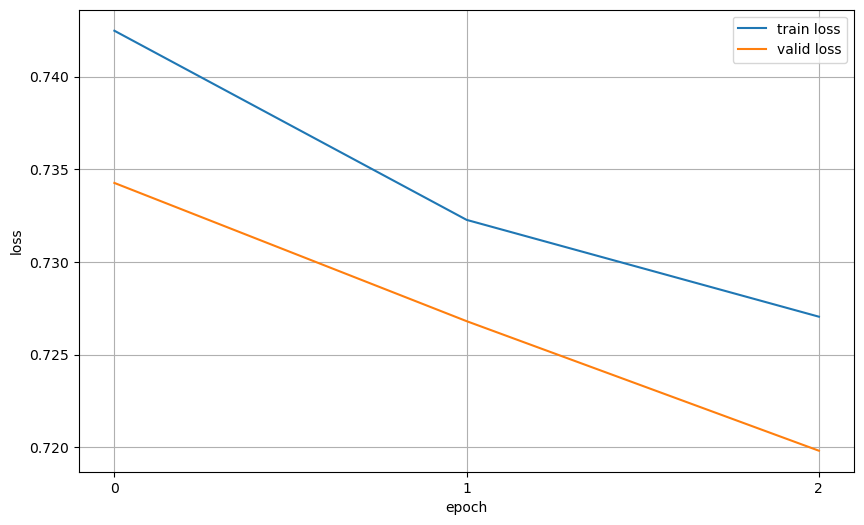

In [28]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_losses"], label="train loss")
ax.plot(metrics["valid_losses"], label="valid loss")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

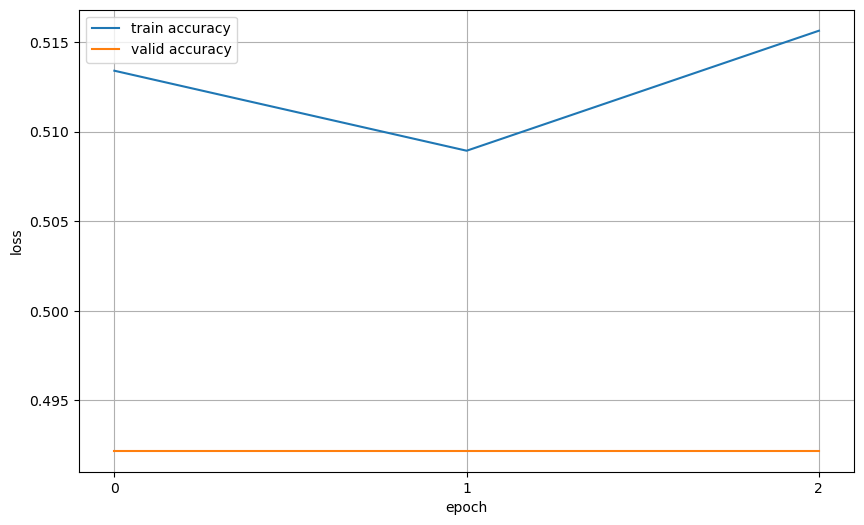

In [29]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
ax.plot(metrics["train_accs"], label="train accuracy")
ax.plot(metrics["valid_accs"], label="valid accuracy")
ax.set_xlabel("epoch")
ax.set_ylabel("loss")
ax.set_xticks(range(n_epochs))
ax.legend()
ax.grid()

In [30]:
model.load_state_dict(torch.load("transformer.pt"))

test_loss, test_acc = evaluate(test_data_loader, model, criterion, device)

evaluating...: 100%|██████████| 2/2 [00:14<00:00,  7.02s/it]


In [31]:
print(f"test_loss: {test_loss:.3f}, test_acc: {test_acc:.3f}")

test_loss: 0.683, test_acc: 0.594


In [32]:
def predict_sentiment(text, model, tokenizer, device):
    ids = tokenizer(text)["input_ids"]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [33]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.5785283446311951)

In [34]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.5859870314598083)

In [35]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.6078446507453918)

In [36]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, device)

(0, 0.6289101243019104)